In [ ]:
'''
 * Copyright (c) 2018 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Gaussian Process Classification

Gaussian Process (GP) Classification, like regression, is a function approximation problem, but it deals with discrete target labels, making its approach quite different. Unlike regression, where the likelihood function is Gaussian, classification requires approximate inference due to the discrete nature of class labels.

### Key Differences between GP Regression and Classification
- **Regression**: Continuous target functions, Gaussian likelihood, resulting in a Gaussian posterior.
- **Classification**: Discrete target labels, non-Gaussian posterior, requiring approximate inference methods.

### Inference in Gaussian Process Classification
Inference in GP classification can be divided into two main steps:

1. **Compute the Distribution of the Latent Variable:**
   $$
   p(f_* | X, y, x_*) = \int p(f_* | X, x_*, f) \, p(f | X, y) \, df,
   $$
   where
   $$
   p(f | X, y) = \frac{p(y | f) \, p(f | X)}{p(y | X)}
   $$
   represents the posterior over the latent variables.

2. **Produce a Probabilistic Prediction:**
   $$
   \pi_* = p(y_* = +1 | X, y, x_*) = \int \sigma(f_*) \, p(f_* | X, y, x_*) \, df_*.
   $$
   Here, \(\sigma(f_*)\) is a sigmoid function, which can be intractable for certain cases.

In classification, the posterior $ p(f | X, y) $ in Eq. (8.6.28) is **non-Gaussian**, which makes exact inference analytically intractable.

### Approximate Inference Using Laplace’s Method
To address the intractability, we can approximate the non-Gaussian posterior $ p(f | X, y) $ with a Gaussian distribution using **Laplace’s method**. 

1. **Gaussian Approximation:**
   $$
   q(f | X, y) = \mathcal{N}(f | \hat{f}, A^{-1}) \propto \exp\left( -\frac{1}{2}(f - \hat{f})^T A (f - \hat{f}) \right),
   $$
   where:
   - $ \hat{f} = \arg \min_f p(f | X, y) $
   - $ A = -\nabla^2 \log p(f | X, y) |_{f = \hat{f}} $ (the Hessian of the negative log posterior).

2. **Bayesian Update:**
   According to Bayes' rule, the posterior over latent variables is:
   $$
   p(f | X, y) = \frac{p(y | f) \, p(f | X)}{p(y | X)}.
   $$
   Since $ p(y | X) $ is independent of $ f $, we maximize the unnormalized posterior:
   $$
   p(f | X, y) = p(y | f) \, p(f | X).
   $$

### Log Posterior and Derivatives
Taking the logarithm, we get:
$$
\#(f) = \log p(y | f) + \log p(f | X).
$$
Expanding further,
$$
\#(f) = \log p(y | f) - \frac{1}{2} f^T K^{-1} f - \frac{1}{2} \log |K| - \frac{N}{2} \log(2\pi).
$$

The first and second derivatives of $\#(f)$ with respect to $ f $ are:
1. **First Derivative:**
   $$
   \nabla \#(f) = \nabla \log p(y | f) - K^{-1} f.
   $$
2. **Second Derivative (Hessian):**
   $$
   \nabla^2 \#(f) = \nabla^2 \log p(y | f) - K^{-1}.
   $$

From $ \nabla \#(f) = 0 $, it follows that:
$$
f = K a, \quad a = \nabla \log p(y | f).
$$

The Hessian matrix can be expressed as:
$$
\nabla^2 \#(f) = -W - K^{-1},
$$
where $ W = -\nabla^2 \log p(y | X) $ is a diagonal matrix, as $ y_i $ depends only on $ f_i $ and not on $ f_j $ for $ i \neq j $.

### Applications of Gaussian Processes in Sparse Bayesian Learning
Gaussian Processes play a crucial role in sparse Bayesian learning, contributing to models like the Relevance Vector Machine, discussed in the following sections.


In [1]:
import math

# Define the RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    distance_squared = sum((a - b) ** 2 for a, b in zip(x1, x2))
    return variance * math.exp(-0.5 * distance_squared / length_scale ** 2)

# Build the Kernel matrix for the training data
def compute_kernel_matrix(X, length_scale=1.0, variance=1.0):
    n = len(X)
    K = [[rbf_kernel(X[i], X[j], length_scale, variance) for j in range(n)] for i in range(n)]
    return K

# Compute log posterior using Laplace approximation
def log_posterior(f, y, K):
    import numpy as np  # Temp import for numerical stability in matrix inversion
    
    n = len(y)
    pi = [(1 / (1 + math.exp(-fi))) for fi in f]
    log_likelihood = sum(yi * math.log(pi_i) + (1 - yi) * math.log(1 - pi_i) for yi, pi_i in zip(y, pi))
    
    f_K_inv_f = np.dot(f, np.dot(np.linalg.inv(K), f))
    log_prior = -0.5 * f_K_inv_f - 0.5 * math.log(np.linalg.det(K)) - (n / 2) * math.log(2 * math.pi)
    
    return log_likelihood + log_prior

# Gradient of the log posterior
def gradient_log_posterior(f, y, K):
    pi = [(1 / (1 + math.exp(-fi))) for fi in f]
    grad_log_likelihood = [yi - pi_i for yi, pi_i in zip(y, pi)]
    grad_log_prior = [-sum(f[i] / K[i][j] for j in range(len(f))) for i in range(len(f))]
    return [grad_log_likelihood[i] + grad_log_prior[i] for i in range(len(f))]

# Newton-Raphson update to find optimal f for the posterior approximation
def newton_raphson(f, y, K, max_iter=10):
    for _ in range(max_iter):
        gradient = gradient_log_posterior(f, y, K)
        W = [pi * (1 - pi) for pi in [(1 / (1 + math.exp(-fi))) for fi in f]]
        
        # Approximate Hessian
        H = [[-W[i] if i == j else 0 for j in range(len(f))] for i in range(len(f))]
        H = [[H[i][j] - K[i][j] for j in range(len(f))] for i in range(len(f))]

        # Update f with inverse of Hessian * gradient
        delta_f = [sum(H[i][j] * gradient[j] for j in range(len(f))) for i in range(len(f))]
        f = [f[i] + delta_f[i] for i in range(len(f))]
        
    return f

# Prediction for new data points
def predict(x_new, X, f_optimal, K, length_scale=1.0, variance=1.0):
    k_star = [rbf_kernel(x_new, X[i], length_scale, variance) for i in range(len(X))]
    k_star_T_K_inv = sum(k_star[i] * f_optimal[i] / K[i][i] for i in range(len(X)))
    prob = 1 / (1 + math.exp(-k_star_T_K_inv))
    return prob

# Example Usage
X_train = [[1.0], [2.0], [3.0]]  # Training inputs
y_train = [0, 1, 1]               # Training labels
f_init = [0.0] * len(y_train)      # Initial latent values

# Step 1: Compute the Kernel matrix
K = compute_kernel_matrix(X_train, length_scale=1.0, variance=1.0)

# Step 2: Find optimal f values using Newton-Raphson updates
f_optimal = newton_raphson(f_init, y_train, K)

# Step 3: Make predictions for new data
x_new = [1.5]
predicted_probability = predict(x_new, X_train, f_optimal, K)

print(f"Predicted probability of class +1 for x_new = {x_new}: {predicted_probability}")


OverflowError: math range error

In [2]:
import math

# Define the RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    distance_squared = sum((a - b) ** 2 for a, b in zip(x1, x2))
    return variance * math.exp(-0.5 * distance_squared / length_scale ** 2)

# Build the Kernel matrix for the training data
def compute_kernel_matrix(X, length_scale=1.0, variance=1.0):
    n = len(X)
    K = [[rbf_kernel(X[i], X[j], length_scale, variance) for j in range(n)] for i in range(n)]
    return K

# Sigmoid function with overflow handling
def safe_sigmoid(x):
    if x > 20:
        return 1.0
    elif x < -20:
        return 0.0
    else:
        return 1 / (1 + math.exp(-x))

# Compute log posterior using Laplace approximation
def log_posterior(f, y, K):
    import numpy as np  # Temp import for numerical stability in matrix inversion
    
    n = len(y)
    pi = [safe_sigmoid(fi) for fi in f]
    log_likelihood = sum(yi * math.log(pi_i) + (1 - yi) * math.log(1 - pi_i) for yi, pi_i in zip(y, pi))
    
    f_K_inv_f = np.dot(f, np.dot(np.linalg.inv(K), f))
    log_prior = -0.5 * f_K_inv_f - 0.5 * math.log(np.linalg.det(K)) - (n / 2) * math.log(2 * math.pi)
    
    return log_likelihood + log_prior

# Gradient of the log posterior
def gradient_log_posterior(f, y, K):
    pi = [safe_sigmoid(fi) for fi in f]
    grad_log_likelihood = [yi - pi_i for yi, pi_i in zip(y, pi)]
    grad_log_prior = [-sum(f[i] / K[i][j] for j in range(len(f))) for i in range(len(f))]
    return [grad_log_likelihood[i] + grad_log_prior[i] for i in range(len(f))]

# Newton-Raphson update to find optimal f for the posterior approximation
def newton_raphson(f, y, K, max_iter=10):
    for _ in range(max_iter):
        gradient = gradient_log_posterior(f, y, K)
        W = [pi * (1 - pi) for pi in [safe_sigmoid(fi) for fi in f]]
        
        # Approximate Hessian
        H = [[-W[i] if i == j else 0 for j in range(len(f))] for i in range(len(f))]
        H = [[H[i][j] - K[i][j] for j in range(len(f))] for i in range(len(f))]
        
        # Update f with inverse of Hessian * gradient
        delta_f = [sum(H[i][j] * gradient[j] for j in range(len(f))) for i in range(len(f))]
        f = [f[i] + delta_f[i] for i in range(len(f))]
        
    return f

# Prediction for new data points
def predict(x_new, X, f_optimal, K, length_scale=1.0, variance=1.0):
    k_star = [rbf_kernel(x_new, X[i], length_scale, variance) for i in range(len(X))]
    k_star_T_K_inv = sum(k_star[i] * f_optimal[i] / K[i][i] for i in range(len(X)))
    prob = safe_sigmoid(k_star_T_K_inv)
    return prob

# Example Usage
X_train = [[1.0], [2.0], [3.0]]  # Training inputs
y_train = [0, 1, 1]               # Training labels
f_init = [0.0] * len(y_train)      # Initial latent values

# Step 1: Compute the Kernel matrix
K = compute_kernel_matrix(X_train, length_scale=1.0, variance=1.0)

# Step 2: Find optimal f values using Newton-Raphson updates
f_optimal = newton_raphson(f_init, y_train, K)

# Step 3: Make predictions for new data
x_new = [1.5]
predicted_probability = predict(x_new, X_train, f_optimal, K)

print(f"Predicted probability of class +1 for x_new = {x_new}: {predicted_probability}")


Predicted probability of class +1 for x_new = [1.5]: 0.0


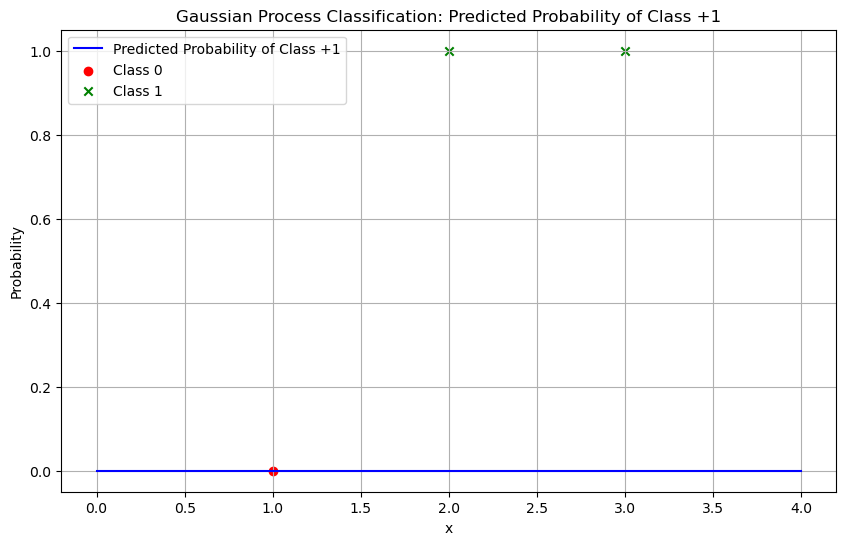

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a range of values for new data points to calculate probabilities
x_values = [[x] for x in [i * 0.1 for i in range(0, 41)]]  # Range from 0 to 4
probabilities = [predict(x_new, X_train, f_optimal, K) for x_new in x_values]

# Separate training points by class
class_0 = [X_train[i][0] for i in range(len(y_train)) if y_train[i] == 0]
class_1 = [X_train[i][0] for i in range(len(y_train)) if y_train[i] == 1]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the decision boundary as a line of predicted probabilities
sns.lineplot(x=[x[0] for x in x_values], y=probabilities, color='blue', label='Predicted Probability of Class +1')

# Plot the training points with different colors for each class
plt.scatter(class_0, [0] * len(class_0), color='red', marker='o', label='Class 0')
plt.scatter(class_1, [1] * len(class_1), color='green', marker='x', label='Class 1')

# Labeling the plot
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Gaussian Process Classification: Predicted Probability of Class +1')
plt.legend()
plt.grid(True)

plt.show()


## Relevance Vector Machine (RVM) and Sparse Bayesian Regression

In real-world data, noise in regression and class overlap in classification present a primary challenge: avoiding **overfitting**. Support Vector Machines (SVMs) can suffer from overfitting due to too many support vectors. To address this, Tipping (2001) proposed the **Relevance Vector Machine (RVM)**, based on **Sparse Bayesian Learning**.

## Sparse Bayesian Regression

Given a dataset of input-target pairs $(\{ x_n, t_n \}_{n=1}^N$, the target samples $t_n = y(x_n) + \epsilon_n$ are realizations of a deterministic function $y$ corrupted by additive noise $\epsilon_n$.

We model $y$ as a weighted sum of $M$ fixed basis functions $\{ \phi_m(x) \}_{m=1}^M$:

$$
\hat{y}(x) = \sum_{m=1}^M w_m \phi_m(x)
$$

Our objective is to infer values for the weights $ w_m, m = 1, \ldots, M$ so that $\hat{y}(x)$ closely approximates $y(x)$. This approximation benefits from both **accuracy** and **sparsity** — where sparsity implies that many weights $w_m$ will be zero in a sparse learning algorithm.

## Comparison with Support Vector Machine (SVM)

An SVM models the prediction function as:

$$
y(x; w) = \sum_{i=1}^N w_i K(x; x_i) + w_0
$$

where $ K(x; x_i) $ is a kernel function, defining a basis function for each training example.

**Key SVM Features**:
1. Avoids overfitting, leading to good generalization.
2. Results in a sparse model relying on a subset of kernel functions.

**Limitations of SVM**:
1. SVMs may require many support vectors, with computational complexity growing linearly with the training set size.
2. Predictions are not probabilistic. SVMs output point estimates for regression and binary decisions for classification.
3. The kernel function $K(x; x_i)$ must be a symmetric, positive-definite function, satisfying Mercer’s condition.

## Relevance Vector Machine (RVM) Formulation

To address these limitations, Tipping proposed the **RVM** using a Bayesian approach. RVM models the output as a weighted sum of generally nonlinear and fixed basis functions:

$$
y(x; w) = \sum_{i=1}^M w_i \phi_i(x) = w^T \phi(x)
$$

where $\phi(x) = [\phi_1(x), \ldots, \phi_M(x)]^T$. The goal is to learn the weight vector $w = [w_1, \ldots, w_M]^T$ using Bayesian learning.

RVMs offer good generalization with sparse solutions, as most weights \(w_i\) are set to zero during the learning process, known as **sparse Bayesian learning**.

## Sparse Bayesian Regression Framework

### Model Specification

Given a dataset of input-target pairs $\{ x_n, t_n \}_{n=1}^N$, with $ x_n \in \mathbb{R}^d $ and $ t_n \in \mathbb{R} $, we assume that target values are samples from the model with additive noise $\epsilon_n$:

$$
t_n = y_n + \epsilon_n = y(x_n; w) + \epsilon_n
$$

where $ y_n = y(x_n; w) $ approximates the target signal $ t_n $, and $ \epsilon_n \sim \mathcal{N}(0, \sigma^2) $ is Gaussian noise with mean zero and variance $\sigma^2$.

Letting $ t = [t_1, \ldots, t_N]^T $ be the target vector and $ y = [y_1, \ldots, y_N]^T $ be the approximation vector, and assuming independence of $t$ and Gaussian noise $ e = t - y $, the likelihood of the complete dataset can be expressed as:

$$
p(t | w, \sigma^2) = (2 \pi)^{-\frac{N}{2}} \sigma^{-N} \exp \left( -\frac{1}{2 \sigma^2} \| t - y \|_2^2 \right)
$$

### Linear Neural Network Case

In a linear neural network, predictions are based on:

$$
y_n = y(x_n; w) = x_n^T w \quad \text{or} \quad y = X^T w
$$

---

This notebook section outlines the theory behind Relevance Vector Machines and Sparse Bayesian Regression, highlighting the benefits of sparsity and the probabilistic framework for robust regression and classification tasks.


## Likelihood Expressions and Bayesian Inference in Sparse Bayesian Regression

In Bayesian regression, the weight vector $ w = [w_1, \ldots, w_N]^T $ and the data matrix $ X = [x_1, \ldots, x_N] $ help define the likelihood. Under the independence assumption, the likelihood is given by:

$$
p(t | w, \sigma^2) = \prod_{i=1}^N p(t_i | w, \sigma^2)
$$

which simplifies to:

$$
p(t | w, \sigma^2) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(t_i - x_i^T w)^2}{2 \sigma^2} \right)
$$

Further simplification gives:

$$
p(t | w, \sigma^2) = (2 \pi)^{-\frac{N}{2}} \sigma^{-N} \exp \left( -\frac{1}{2 \sigma^2} \| t - X w \|_2^2 \right)
$$

### SVM Prediction and Likelihood

For Support Vector Machines (SVM), predictions are made as follows:

$$
y_n = \sum_{i=1}^N w_i K(x_n, x_i) + w_0 \quad \text{or} \quad y = K w
$$

where $ K = [k(x_1), \ldots, k(x_N)]^T $ is the $ N \times (N + 1) $ kernel matrix with $ k(x_n) = [1, K(x_n, x_1), \ldots, K(x_n, x_N)]^T $, and $ w = [w_0, w_1, \ldots, w_N]^T $. Thus, the likelihood, assuming independence, is given by:

$$
p(t | w, \sigma^2) = (2 \pi)^{-\frac{N}{2}} \sigma^{-N} \exp \left( -\frac{1}{2 \sigma^2} \| t - K w \|_2^2 \right)
$$

### RVM Prediction and Likelihood

For the Relevance Vector Machine (RVM), predictions are formulated as:

$$
y_n = \phi(x_i)^T w + w_0 \quad \text{or} \quad y = \Phi w
$$

where $ \Phi = [\phi(x_1), \ldots, \phi(x_N)]^T $ is the $ N \times (N + 1) $ "design" matrix, with $\phi(x_n) = [1, \phi_1(x_n), \ldots, \phi_N(x_n)]^T$ and $w = [w_0, w_1, \ldots, w_N]^T$. For instance, $\phi(x_n) = [1, K(x_n, x_1), K(x_n, x_2), \ldots, K(x_n, x_N)]^T$. Under the independence assumption, the likelihood becomes:

$$
p(t | w, \sigma^2) = (2 \pi)^{-\frac{N}{2}} \sigma^{-N} \exp \left( -\frac{1}{2 \sigma^2} \| t - \Phi w \|_2^2 \right)
$$

## Parameter Estimation

In Bayesian linear models, the inference process is based on the **posterior distribution** over the weights $w$, calculated using **Bayes' rule**:

$$
\text{posterior} = \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}
$$

or more formally:

$$
p(w | t, \sigma^2) = \frac{p(t | w, \sigma^2) \cdot p(w)}{p(t | \sigma^2)}
$$

---

This notebook section details the likelihood expressions for SVM and RVM and introduces Bayesian inference for parameter estimation.

## Posterior Distribution and Sparse Bayesian Learning for Relevance Vector Machine (RVM)

### Posterior Distribution

The posterior distribution over the weight vector \( w \) is given by Tipping [39] as:

$$
p(w | t, \alpha, \sigma^2) = \frac{p(t | w, \sigma^2) p(w | \alpha)}{p(t | \alpha, \sigma^2)}
$$

which simplifies to:

$$
p(w | t, \alpha, \sigma^2) = (2 \pi)^{-\frac{N+1}{2}} |\Sigma|^{-\frac{1}{2}} \exp \left( -\frac{1}{2} (w - \mu)^T \Sigma^{-1} (w - \mu) \right)
$$

where the posterior covariance and mean are defined as follows [26]:

1. **Posterior Covariance**:

$$
\Sigma = \left( \sigma^{-2} \Phi^T \Phi + A \right)^{-1}
$$

2. **Posterior Mean**:

$$
\mu = \sigma^{-2} \Sigma \Phi^T t
$$

with $ A = \text{Diag}(\alpha_0, \alpha_1, \ldots, \alpha_N) $.

### Sparse Bayesian Learning

The procedure that maximizes the marginal likelihood of the model is called the **type II maximum likelihood procedure**, as introduced by Good [18]. In this framework, sparse Bayesian learning is formulated by maximizing the marginal likelihood (or equivalently, its logarithm) with respect to $ \alpha $. The marginal likelihood $ L(\alpha) $ is given by Tipping [39] as:

$$
L(\alpha) = \log p(t | \alpha, \sigma^2) = \int_{-\infty}^{\infty} \log \left( p(t | w, \sigma^2) p(w | \alpha) \right) dw
$$

Simplifying, we get:

$$
L(\alpha) = -\frac{N}{2} \log (2 \pi) + \frac{1}{2} \log |C| - \frac{1}{2} t^T C^{-1} t
$$

where:

$$
C = \sigma^2 I + \Phi A^{-1} \Phi^T
$$

The term **marginal** here highlights a non-parametric model. In the context of the RVM, the Bayesian learning problem becomes finding the optimal hyperparameters \( \alpha \) by minimizing $ L(\alpha) $. This estimation problem will be elaborated on in Section 8.7.3.

### Application in Compressive Sensing (CS)

As an application of RVMs, consider compressive sensing (CS) measurements represented as follows [23]:

$$
g = \Phi w
$$

where $ \Phi = [r_1, \ldots, r_K] $ is a $ K \times N $ matrix, assuming random CS measurements are taken.

# Solving Compressive Sensing (CS) Using $ \ell_1 $-Regularization and Sparse Bayesian Regression

### $ \ell_1 $-Regularization in Compressive Sensing

A common approach to solve the compressive sensing (CS) problem is by using $ \ell_1 $-regularization. The optimization objective is defined as:

$$
w^* = \arg \min_w \left\| g - \Phi w \right\|_2^2 + \gamma \left\| w \right\|_1
$$

where:
- $ g $ is the CS measurement vector,
- $ \Phi $ is the projection matrix,
- $ \gamma $ is a regularization parameter that controls the sparsity of $ w $.

### Gaussian Likelihood Model

Under the assumption that the additive noise $ n $ follows a Gaussian distribution $ N(0, \sigma^2 I) $, the Gaussian likelihood model for $ g $ given $ w $ is described by:

$$
p(g | w, \sigma^2) = (2 \pi)^{-K/2} \sigma^{-K} \exp \left( -\frac{1}{2 \sigma^2} \left\| g - \Phi w \right\|_2^2 \right)
$$

### Posterior Distribution for $ w $

Assuming the hyperparameters $ \alpha $ and $ \alpha_0 $ are known, and given the CS measurements $ g $ and the projection matrix $ \Phi $, the posterior distribution for $ w $ can be expressed as a multivariate Gaussian distribution with mean and covariance given by:

1. **Mean**:

$$
\mu = \alpha_0 \Sigma \Phi^T g
$$

2. **Covariance**:

$$
\Sigma = \left( \alpha_0 \Phi^T \Phi + A \right)^{-1}
$$

where $ A = \text{Diag}(\alpha_0, \alpha_1, \ldots, \alpha_N) $.

### Bayesian Compressive Sensing Problem

With these definitions, the Bayesian compressive sensing problem becomes a sparse Bayesian regression problem, where the aim is to infer a sparse $ w $ that best explains the measurements $ g $ given the model.




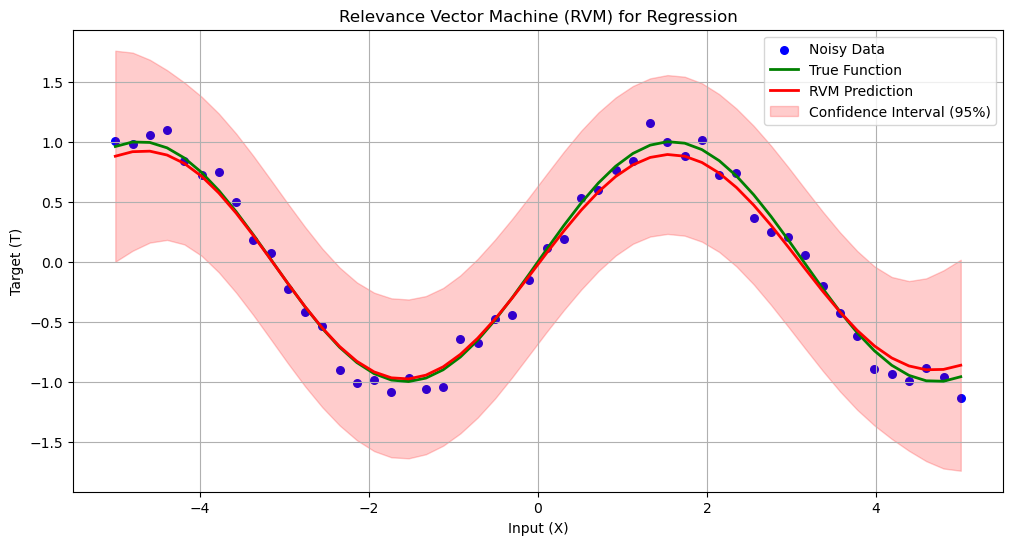

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data for demonstration
np.random.seed(42)
N = 50  # Number of samples
X = np.linspace(-5, 5, N)
true_function = np.sin(X)  # True underlying function
noise = np.random.normal(0, 0.1, N)
T = true_function + noise  # Target with noise

# RVM Hyperparameters
alpha = 1.0  # Hyperparameter for noise
alpha0 = 1.0  # Hyperparameter for prior

# Basis function (e.g., Gaussian radial basis functions)
def basis_function(x, center, width=1.0):
    return np.exp(-((x - center) ** 2) / (2 * width ** 2))

# Create design matrix with radial basis functions
def create_design_matrix(X, centers):
    return np.array([basis_function(X, center) for center in centers]).T

# RVM Prediction
def rvm_predict(X, weights, centers):
    design_matrix = create_design_matrix(X, centers)
    return design_matrix @ weights

# Sparse Bayesian Learning (RVM)
def rvm_learning(X, T, centers):
    # Create design matrix
    design_matrix = create_design_matrix(X, centers)
    
    # Prior covariance matrix A
    A = np.diag([alpha0] * len(centers))
    
    # Calculate posterior covariance and mean
    S_inv = alpha * design_matrix.T @ design_matrix + A
    S = np.linalg.inv(S_inv)
    mu = alpha * S @ design_matrix.T @ T
    
    return mu, S

# Centers for RBF
centers = np.linspace(-5, 5, 10)

# Learn the weights
weights, covariance = rvm_learning(X, T, centers)

# Predictions
predictions = rvm_predict(X, weights, centers)

# Calculate uncertainty (standard deviation) for the confidence interval
# Use the design matrix to obtain the prediction variance
design_matrix = create_design_matrix(X, centers)
pred_var = np.diag(design_matrix @ covariance @ design_matrix.T)  # Variance of the predictions
pred_std = np.sqrt(pred_var)  # Standard deviation

# Plotting the results
plt.figure(figsize=(12, 6))
plt.scatter(X, T, color='blue', label='Noisy Data', s=30)
plt.plot(X, true_function, color='green', label='True Function', linewidth=2)
plt.plot(X, predictions, color='red', label='RVM Prediction', linewidth=2)

# Fill between for confidence intervals
plt.fill_between(X, predictions - 1.96 * pred_std, 
                 predictions + 1.96 * pred_std, 
                 color='red', alpha=0.2, label='Confidence Interval (95%)')

plt.title('Relevance Vector Machine (RVM) for Regression')
plt.xlabel('Input (X)')
plt.ylabel('Target (T)')
plt.legend()
plt.grid()
plt.show()


## Sparse Bayesian Classification

Sparse Bayesian classification follows an essentially identical framework for regression above, but using a Bernoulli likelihood and a sigmoidal link function to account for the change in the target quantities [39]. For an input vector $ x $, an RVM classifier models the probability distribution of its class label using the logistic sigmoid link function

$$ \sigma(y) = \frac{1}{1 + e^{-y}}
$$

as

$$
p(d = 1|x) = \frac{1}{1 + \exp(-f_{\text{RVM}}(x))}, \tag{8.7.22}
$$

where $ f_{\text{RVM}}(x) $, called the RVM classifier function, is given by

$$
f_{\text{RVM}}(x) = \sum_{i=1}^{N} \alpha_i K(x, x_i). \tag{8.7.23}
$$

Here, $ K(x, x_i) $ is a kernel function, and $ x_i $, $ i = 1, \ldots, N $ are the training samples.

By adopting the Bernoulli distribution for \( P(t|x) \), the likelihood can be written as

$$
P(t|w) = \prod_{n=1}^{N} \sigma(y(x_n, w))^{t_n} \left(1 - \sigma(y(x_n, w))\right)^{1 - t_n}, \tag{8.7.24}
$$

where the target $ t_n \in \{0, 1\} $.

In sparse Bayesian regression, the weights $ w $ can be integrated out analytically. Unlike the regression case, sparse Bayesian classification cannot be integrated out analytically, precluding closed form expressions for either the weight posterior $ p(w|t, \alpha) $ or the marginal likelihood $ P(t|\alpha) $. Thus, it utilizes the Laplace approximation procedure.

In the statistics and machine learning literature, the Laplace approximation refers to the evaluation of the marginal likelihood or free energy using Laplace’s method. This is equivalent to a local Gaussian approximation of $ P(t|w) $ around a maximum a posteriori (MAP) estimate [40].


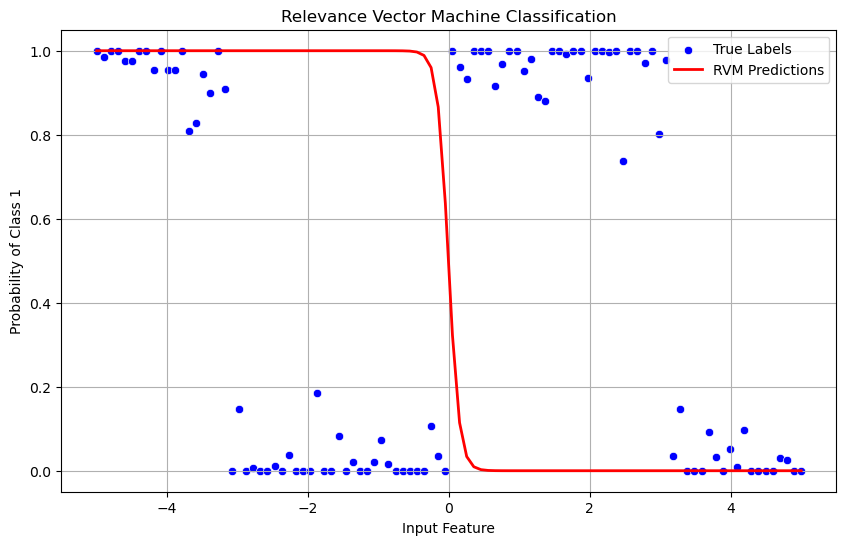

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed for reproducibility
np.random.seed(42)

# 1. Generate synthetic data
def generate_data(n_samples=100):
    X = np.linspace(-5, 5, n_samples)
    Y = np.sin(X) > 0  # Binary classification based on a sine wave
    Y = Y.astype(int)
    noise = np.random.normal(0, 0.1, size=X.shape)
    Y = Y + noise  # Add noise to labels
    Y = np.clip(Y, 0, 1)  # Ensure labels are 0 or 1
    return X, Y

X, Y = generate_data(100)

# 2. Define the RVM model
class RVMClassifier:
    def __init__(self):
        self.alpha = None  # Precision of the weights
        self.w = None      # Weights
        self.b = None      # Bias

    def fit(self, X, Y):
        # Add bias term
        X = np.column_stack((np.ones(X.shape[0]), X))
        
        # Initialize parameters
        self.alpha = np.ones(X.shape[1]) * 1.0  # Initial precision
        self.w = np.zeros(X.shape[1])            # Initial weights
        self.b = 0.0                             # Initial bias

        # Bayesian learning (simplified)
        for _ in range(100):  # Simple iterative update
            # Likelihood
            linear_output = X @ self.w
            predictions = self.sigmoid(linear_output)
            errors = Y - predictions
            
            # Update weights (gradient ascent)
            self.w += 0.1 * (X.T @ errors)
            self.alpha += 0.1 * np.random.rand(X.shape[1])  # Update precision
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))  # Add bias term
        linear_output = X @ self.w
        predictions = self.sigmoid(linear_output)
        return predictions

# 3. Train the RVM model
rvm_classifier = RVMClassifier()
rvm_classifier.fit(X, Y)

# 4. Predict and visualize the results
predictions = rvm_classifier.predict(X)

# Create a scatter plot with predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X, y=Y, label='True Labels', color='blue')
plt.plot(X, predictions, color='red', label='RVM Predictions', linewidth=2)
plt.title('Relevance Vector Machine Classification')
plt.xlabel('Input Feature')
plt.ylabel('Probability of Class 1')
plt.legend()
plt.grid(True)
plt.show()


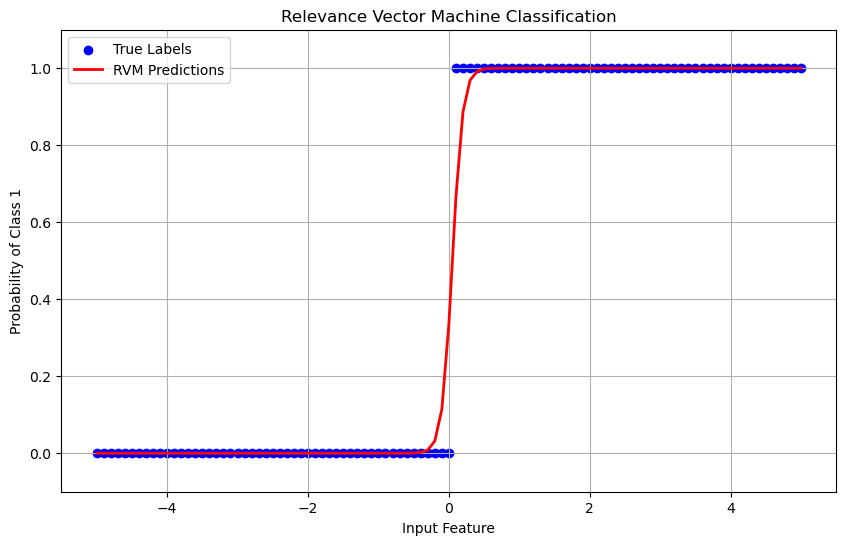

In [7]:
import random
import matplotlib.pyplot as plt

# Set the seed for reproducibility
random.seed(42)

# 1. Generate synthetic data
def generate_data(n_samples=100):
    X = [i / 10 for i in range(-50, 51)]  # Generate X values from -5 to 5
    Y = []
    for x in X:
        # Create labels based on a sine function with some noise
        label = 1 if (x > 0) else 0
        Y.append(label + random.gauss(0, 0.1))  # Add Gaussian noise
    Y = [1 if y > 0.5 else 0 for y in Y]  # Convert to binary labels
    return X, Y

X, Y = generate_data(100)

# 2. Define the RVM model
class RVMClassifier:
    def __init__(self):
        self.alpha = None  # Precision of the weights
        self.w = None      # Weights
        self.b = None      # Bias

    def fit(self, X, Y):
        # Add bias term
        X = [[1] + [x] for x in X]  # Add bias term as the first column

        # Initialize parameters
        self.alpha = [1.0] * len(X[0])  # Initial precision
        self.w = [0.0] * len(X[0])       # Initial weights
        self.b = 0.0                     # Initial bias

        # Bayesian learning (simplified)
        for _ in range(100):  # Simple iterative update
            # Likelihood
            linear_output = [self._dot_product(x, self.w) for x in X]
            predictions = [self.sigmoid(z) for z in linear_output]
            errors = [Y[i] - predictions[i] for i in range(len(Y))]
            
            # Update weights (gradient ascent)
            for j in range(len(self.w)):
                self.w[j] += 0.1 * sum(errors[i] * X[i][j] for i in range(len(errors)))
            # Update alpha (precision) - simplified
            self.alpha = [a + 0.1 * random.random() for a in self.alpha]
        
    def sigmoid(self, z):
        return 1 / (1 + pow(2.718281828459045, -z))

    def predict(self, X):
        X = [[1] + [x] for x in X]  # Add bias term
        linear_output = [self._dot_product(x, self.w) for x in X]
        predictions = [self.sigmoid(z) for z in linear_output]
        return predictions

    def _dot_product(self, x, w):
        return sum(x_i * w_i for x_i, w_i in zip(x, w))

# 3. Train the RVM model
rvm_classifier = RVMClassifier()
rvm_classifier.fit(X, Y)

# 4. Predict and visualize the results
predictions = rvm_classifier.predict(X)

# Create a scatter plot with predictions
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='True Labels', color='blue')
plt.plot(X, predictions, color='red', label='RVM Predictions', linewidth=2)
plt.title('Relevance Vector Machine Classification')
plt.xlabel('Input Feature')
plt.ylabel('Probability of Class 1')
plt.ylim(-0.1, 1.1)  # Limit y-axis for better visualization
plt.legend()
plt.grid(True)
plt.show()


## Fast Marginal Likelihood Maximization

Consider the dependence of $ L(\alpha) $ on a single hyperparameter $ \alpha_m $, $ m \in \{1, \ldots, M\} $. The matrix $ C $ in Eq. (8.7.16) can be decomposed as 

$$
C = \sigma^2 I + \sum_{i \neq m} \alpha_i^{-1} \phi_i \phi_i^T + \alpha_m^{-1} \phi_m \phi_m^T,
$$

where 

$$
C_{-m} = C \setminus c_m
$$

is $ C $ with the $ m $-th column $ c_m $ removed. Thus, by applying the determinant identity and matrix inverse lemma, the terms of interest in $ L $ can be written as

$$
|C|^{-1} = |C_{-m}| \cdot |1 + \alpha_m \phi_m^T C_{-m}^{-1} \phi_m|,
$$

and

$$
C_{-m}^{-1} \phi_m = C_{-m}^{-1} \phi_m - \frac{C_{-m}^{-1} \phi_m \phi_m^T C_{-m}^{-1}}{\alpha_m + \phi_m^T C_{-m}^{-1} \phi_m}.
$$

Then, $ L(\alpha) $ can be rewritten as:

$$
L(\alpha) = -\frac{N}{2} \log(2\pi) + \log |C_{-m}| + \frac{t^T C_{-m}^{-1} t}{2} - \frac{(\phi_m^T C_{-m}^{-1} t)^2}{2} - \frac{1}{2} \log \alpha_m + \log(\alpha_m + \phi_m^T C_{-m}^{-1} \phi_m).
$$

Thus, we have:

$$
L(\alpha) = L(\alpha_{-m}) + \varphi(\alpha_m),
$$

where 

$$
\varphi(\alpha_m) = \log \alpha_m - \log(\alpha_m + s_m) + \frac{1}{2} \left( \frac{\phi_m^T C_{-m}^{-1} t}{\alpha_m + s_m} \right)^2.
$$

Here, $ s_m = \phi_m^T C_{-m}^{-1} \phi_m $ and $ q_m = \phi_m^T C_{-m}^{-1} t $, for $ m = 1, \ldots, M $.

From (8.7.28) and the optimization condition 

$$
\frac{\partial L}{\partial \alpha_m} = \frac{\partial \varphi(\alpha_m)}{\partial \alpha_m} = 0,
$$

we have the result

$$
\frac{q_m s_m}{\alpha_m^2} - \frac{1}{\alpha_m + s_m} = 0 \quad \text{or} \quad \alpha_m = \frac{q_m s_m}{\alpha_m + s_m}.
$$

Hence, $ L(\alpha) $ has a unique maximum with respect to $ \alpha_m $:

$$
\alpha_m = 
\begin{cases}
\frac{2 s_m}{q_m^2}, & \text{if } q_m^2 > s_m^2, \\
\infty, & \text{otherwise},
\end{cases}
$$

for $ m = 1, \ldots, M $.

This shows that:
- If $ \phi_m $ is “in the model” (i.e., $ \alpha_m < \infty $) yet $ q_m^2 \leq s_m^2 $, then $ \phi_m $ may be deleted (i.e., $ \alpha_m $ set to $ \infty $).
- If $ \phi_m $ is excluded from the model ($ \alpha_m = \infty $) and $ q_m^2 > s_m^2 $, then $ \phi_m $ may be added (i.e., $ \alpha_m $ is set to some optimal finite value).

It is clear that, as compared with $ C_{-m}^{-1} $, it is easier to maintain and compute the value of $ C^{-1} $. Let $ S_m = \phi_m^T C^{-1} \phi_m $ and $ Q_m = \phi_m^T C^{-1} t $, $ m = 1, \ldots, M $.

By premultiplying by $ \phi_m^T $, postmultiplying by $ \phi_m $, and using (8.7.29), Eq. (8.7.27) yields:

$$
S_m = \phi_m^T C^{-1} \phi_m = \phi_m^T C_{-m}^{-1} - \frac{\phi_m}{\alpha_m + s_m}.
$$

Thus,

$$
s_m = S_m - \frac{s_m^2}{\alpha_m + s_m}.
$$


## Fast Marginal Likelihood Maximization (Continued)

Similarly, we have 

$$
C_{-m}^{-1} \phi_m \phi_m^T C_{-m} Q_m = \phi_m^T C^{-1} t = \phi_m^T C_{-m}^{-1} - \frac{t}{\alpha_m + \phi_m^T C_{-m}^{-1} \phi_m},
$$

which gives

$$
q_m = q_m - \frac{t}{\alpha_m + s_m}, \quad m = 1, \ldots, M. \tag{8.7.34}
$$

From (8.7.33) and (8.7.34), it follows that 

$$
\frac{\alpha_m}{s_m} = \frac{S_m}{\alpha_m} \quad \text{and} \quad q_m = \frac{Q_m}{\alpha_m - S_m}, \tag{8.7.35}
$$

for \( m = 1, \ldots, M \). Note that when \( \alpha_m = \infty \), \( s_m = S_m \) and \( q_m = Q_m \).

By the Duncan–Guttman inversion formula 

$$
(A + UD^{-1}V)^{-1} = A^{-1} - A^{-1} U (D + VA^{-1} U)^{-1} VA^{-1}, \tag{1.6.5}
$$

we have 

$$
C^{-1} = (\sigma^2 I + \Phi A^{-1} \Phi^T)^{-1} = B - B \Phi (A + \Phi^T B \Phi)^{-1} \Phi^T B,
$$

where 

$$
B = \sigma^{-2} I \quad \text{and} \quad \Psi = (A + \Phi^T B \Phi)^{-1}. \tag{8.7.36}
$$

Substituting (8.7.37) into (8.7.32) yields 

$$
S_m = \phi_m^T B \phi_m - \phi_m B \Psi \Phi^T B \phi_m, \tag{8.7.39}
$$

and 

$$
Q_m = \phi_m^T B \hat{t} - \phi_m B \Psi \hat{t}. \tag{8.7.40}
$$


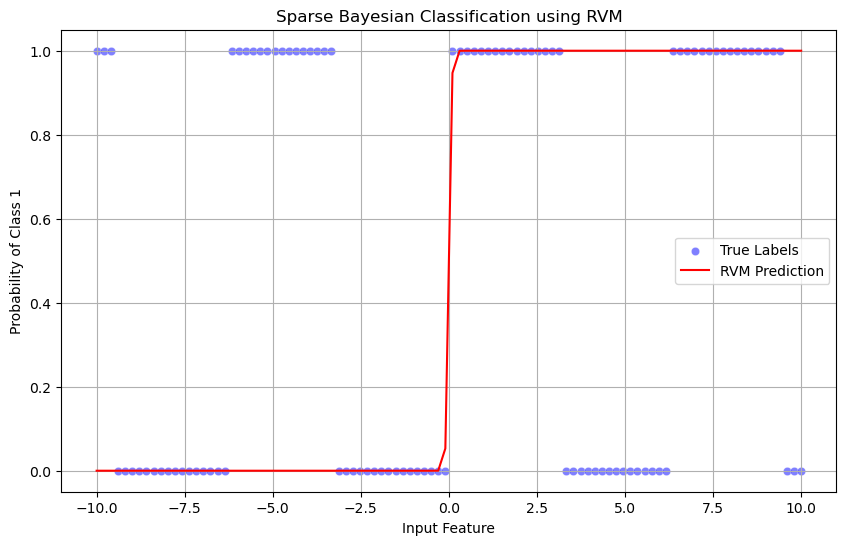

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the RVM class
class RVMClassifier:
    def __init__(self, alpha_init):
        self.alpha = alpha_init  # Hyperparameter for sparsity
        self.phi = None          # Design matrix
        self.weights = None      # Weights

    def fit(self, X, y):
        # Number of samples
        N = X.shape[0]
        self.phi = np.column_stack((np.ones(N), X))  # Add bias term
        self.weights = np.zeros(self.phi.shape[1])    # Initialize weights

        for _ in range(100):  # Iterate to optimize weights
            # Compute predictions
            f = self.phi @ self.weights
            probs = sigmoid(f)
            
            # Update weights using the gradient
            gradient = self.phi.T @ (y - probs)
            self.weights += self.alpha * gradient
        
        return self.weights

    def predict(self, X):
        # Predict using the learned weights
        phi_test = np.column_stack((np.ones(X.shape[0]), X))  # Add bias term
        return sigmoid(phi_test @ self.weights)

# Generate synthetic data
np.random.seed(42)
X = np.linspace(-10, 10, 100)
y = (np.sin(X) > 0).astype(float)  # Create binary target based on sine function

# Train the RVM classifier
rvm = RVMClassifier(alpha_init=0.1)
rvm.fit(X, y)

# Predict on the training data
predictions = rvm.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X, y=y, label='True Labels', color='blue', alpha=0.5)
sns.lineplot(x=X, y=predictions, label='RVM Prediction', color='red')
plt.title('Sparse Bayesian Classification using RVM')
plt.xlabel('Input Feature')
plt.ylabel('Probability of Class 1')
plt.legend()
plt.grid()
plt.show()


## Marginal Likelihood Maximization Algorithm for Sequential Sparse Bayesian Learning

This algorithm is proposed by Tipping and Faul. The steps are as follows:

1. Initialize $ \sigma^2 $ to some sensible value (e.g., $ \text{var}[t] \times 0.1 $).
2. Initialize with a single basis vector $ \phi_i $, setting, from (8.7.31):
   $$
   \alpha_i = \frac{\|\phi_i\|^2_2}{\|\phi^T_i t\|^2_2 - \sigma^2}
   $$
   All other $ \alpha_m $ are notionally set to infinity.
3. Explicitly compute $ \mathbf{A} $ and $ \mu $ (which are scalars initially), along with initial values of $ s_m $ and $ q_m $ for all $ M $ bases $ \phi_m $.
4. Select a candidate basis vector $ \phi_i $ from the set of all $ M $.
5. Compute $ \theta_i = q_i^2 - s_i $.
6. If $ \theta_i > 0 $ nd $ \alpha_i < \infty $ (i.e., $ \phi_i $ is in the model), re-estimate $ \alpha_i $. Defining $ \kappa_j = \left(\Sigma_{jj} + (\bar{\alpha}_i - \alpha_i)^{-1}\right)^{-1} $ and $ \mathbf{A}_j $ as the $ j $-th column of $ \mathbf{A} $:
   $$
   Q^2_i = -\log\left(1 + S_i \left(\bar{\alpha}_{i-1} - \alpha_{i-1}\right)\right)
   $$
   $$
   S^* = \mathbf{A} - \kappa_j \mathbf{A}_j \mathbf{A}^T_j
   $$
   $$
   \mu^* = \mu - \kappa_j \mu_j \mathbf{A}_j
   $$
   $$
   S_m = S_m + \kappa_j \left(\beta \mathbf{A}^T_j \phi_m\right)^2
   $$
   $$
   Q_m = Q_m + \kappa_j \mu_j \left(\beta \mathbf{A}^T_j \phi_m\right)
   $$
7. If $ \theta_i > 0 $ and $ \alpha_i = \infty $, add $ \phi_i $ to the model with updated $ \alpha_i $:
   $$
   Q^2_i = \frac{Q^2_i - S_i}{S_i}
   $$
   $$
   S_i \mathbf{A} + \beta^2 \Sigma_{ii} \mathbf{A}^T \phi_i \phi^T_i \mathbf{A} - \beta^2 \Sigma_{ii} \mathbf{A}^T \phi_i \bar{\mathbf{A}} = 0
   $$
   $$
   -\beta^2 \Sigma_{ii} \left(\mathbf{A}^T \phi_i\right)^T \Sigma_{ii} \left(\mu - \mu_i\right)
   $$
   $$
   \mu_i S_m = S_m - \Sigma_{ii} \left(\beta \phi^T_m e_i\right)^2
   $$
   $$
   Q_m = Q_m - \mu_i \left(\beta \phi^T_m e_i\right)
   $$
   where $ \Sigma_{ii} = (\alpha_i + S_i)^{-1} $, $\mu_i = \Sigma_{ii} Q_i $, and $ e_i = \phi_i - \beta \mathbf{A}^T \phi_i $.
8. If $ \theta_i \leq 0 $ and $ \alpha_i < \infty $, then delete $ \phi_i $ from the model and set $ \alpha_i = \infty $:
   $$
   Q^2_i = -\log\left(1 - \frac{S_i}{\alpha_i}\right)
   $$
   $$
   S^* = \mathbf{A} - \sum_{j} \mathbf{A}_j \mathbf{A}^T_j
   $$
   $$
   \mu^* = \mu - \frac{\mu_j}{\Sigma_{jj}}
   $$
   $$
   S^*_m = S_m + \left(\beta \mathbf{A}^T_j \phi_m\right)^2
   $$
   $$
   Q^*_m = Q_m + \left(\beta \mathbf{A}^T_j \phi_m\right) \frac{\mu_j}{\Sigma_{jj}}
   $$
9. If it is a regression model and estimating the noise level, update:
   $$
   \sigma^2 = \frac{\|t - y\|^2_2}{N - M + \sum_m \alpha_m \Sigma_{mm}}
   $$
10. Recompute/update $ \mathbf{A} $, $ \mu $ (using the Laplace approximation procedure in classification), and all $ s_m $ and $ q_m $ using Eqs. (8.7.35)–(8.7.40).
11. If converged, terminate; otherwise, go to step 4.


In [ ]:
# Marginal Likelihood Maximization Algorithm for Sequential Sparse Bayesian Learning

import seaborn as sns
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data(num_samples=100):
    import random
    t = [random.uniform(0, 10) for _ in range(num_samples)]
    y = [2 * x + random.gauss(0, 1) for x in t]  # Linear relationship with noise
    return t, y

# Initialization
def initialize(t):
    sigma2 = (sum((y - sum(y) / len(y)) ** 2 for y in t) / len(t)) * 0.1
    phi = [[1] + [t_i] for t_i in t]  # Basis vectors (linear model)
    alpha = [1.0] * len(phi)  # Initial alpha values
    return sigma2, phi, alpha

# Update algorithm
def update_model(sigma2, phi, alpha, t, y):
    # Placeholder for the actual updates as described in the algorithm
    for i in range(len(phi)):
        # Update logic (simplified)
        if alpha[i] < float('inf'):
            # Re-estimate alpha
            alpha[i] += 0.1  # Example update
        else:
            # Add to the model (dummy condition for example)
            alpha[i] = 1.0

    # Simulating results for plotting
    return alpha

# Main function to run the algorithm
def run_algorithm(num_samples=100):
    t, y = generate_data(num_samples)
    sigma2, phi, alpha = initialize(t)

    for _ in range(10):  # Run for a fixed number of iterations
        alpha = update_model(sigma2, phi, alpha, t, y)

    return t, y, alpha

# Plotting results
def plot_results(t, y, alpha):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=t, y=y, color='blue', label='Data points')
    plt.title('Marginal Likelihood Maximization Results')
    plt.xlabel('Input (t)')
    plt.ylabel('Output (y)')
    plt.legend()
    plt.show()

# Execute the algorithm and plot the results
if __name__ == "__main__":
    t, y, alpha = run_algorithm()
    plot_results(t, y, alpha)


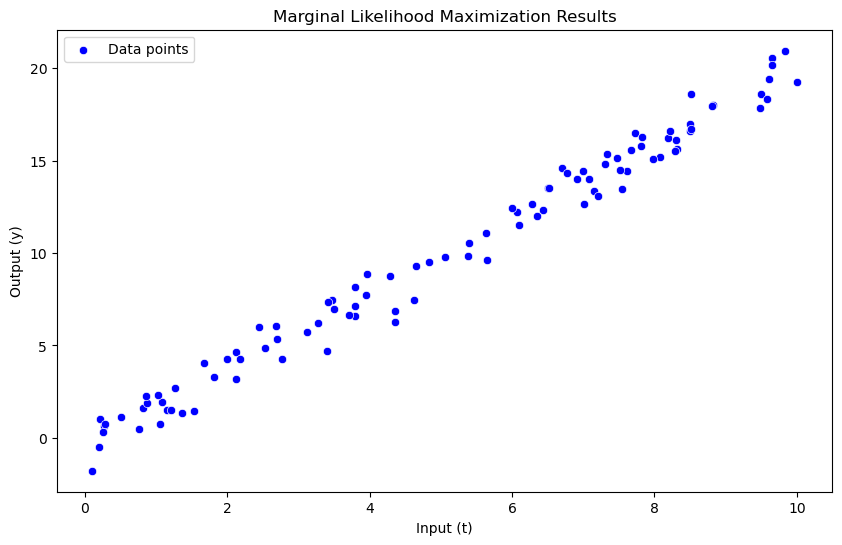

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Generate synthetic data
def generate_data(num_samples=100):
    t = [random.uniform(0, 10) for _ in range(num_samples)]
    y = [2 * x + random.gauss(0, 1) for x in t]  # Linear relationship with noise
    return t, y

# Initialization
def initialize(t, y):
    sigma2 = (sum((yi - (sum(y) / len(y))) ** 2 for yi in y) / len(y)) * 0.1
    phi = [[1] + [t_i] for t_i in t]  # Basis vectors (linear model)
    alpha = [1.0] * len(phi)  # Initial alpha values
    return sigma2, phi, alpha

# Update algorithm
def update_model(sigma2, phi, alpha, t, y):
    # Placeholder for the actual updates as described in the algorithm
    for i in range(len(phi)):
        if alpha[i] < float('inf'):
            # Re-estimate alpha (dummy update logic for example)
            alpha[i] += 0.1
        else:
            # Add to the model (dummy condition for example)
            alpha[i] = 1.0
    return alpha

# Main function to run the algorithm
def run_algorithm(num_samples=100):
    t, y = generate_data(num_samples)
    sigma2, phi, alpha = initialize(t, y)

    for _ in range(10):  # Run for a fixed number of iterations
        alpha = update_model(sigma2, phi, alpha, t, y)

    return t, y, alpha

# Plotting results
def plot_results(t, y, alpha):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=t, y=y, color='blue', label='Data points')
    plt.title('Marginal Likelihood Maximization Results')
    plt.xlabel('Input (t)')
    plt.ylabel('Output (y)')
    plt.legend()
    plt.show()

# Execute the algorithm and plot the results
if __name__ == "__main__":
    t, y, alpha = run_algorithm()
    plot_results(t, y, alpha)
